# Anatomy of a Modulus Project

Now that we've explored the theory behind PINNs, let's take a look how this is done using the Modulus APIs.

Modulus is a framework developed on top of PyTorch to aid the setup and simulation of such data-driven and physics-driven problems. It comes pre-built with several performance optimizations, user-friendly APIs, and a variety of neural networks that allow the solution to very complex problems in the areas of design space exploration, digital twin’s and inverse modeling. 

Let's start by having a look at the general workflow for Modulus projects.

# General Workflow for Modulus Projects

While each problem has its own unique components, the general workflow when developing AI in Modulus follows the workflow in the figure below. The process can be distilled into the following key steps:

1. Initialize Hydra using the Modulus main decorator to read in the configuration YAML.

2. Load necessary data if needed.

3. Define the geometry of the system if needed.

4. Create any Nodes required, such as your neural network model.

5. Create a training domain object.

6. Create constraints and add each to the domain.

7. Create any inferencers, validators or monitors needed.

8. Initialize a solver with the populated training domain.

9. Run the solver, beginning optimization.

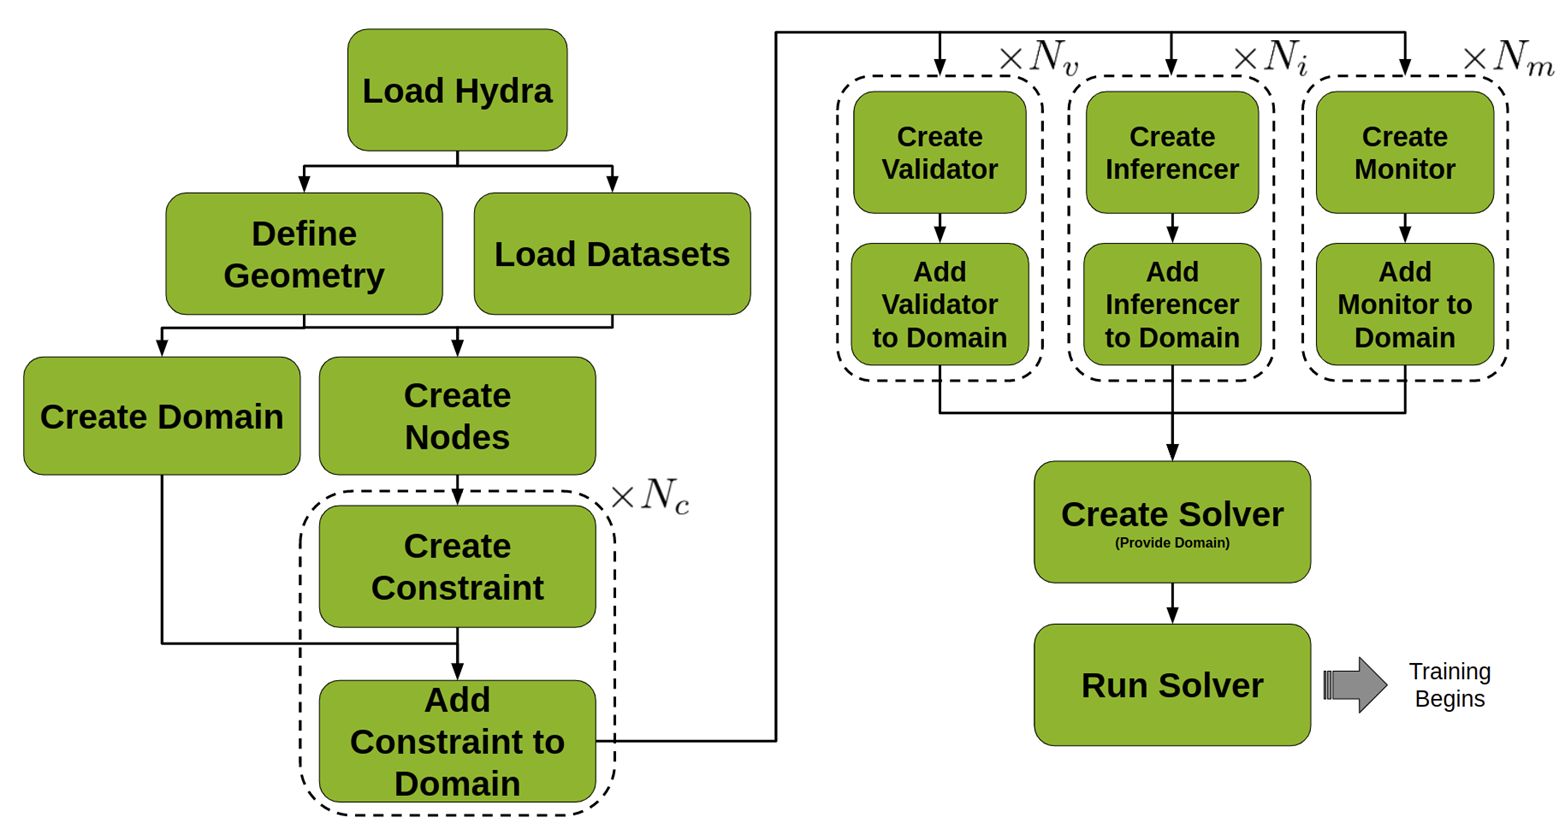

Let's quickly dive into how those individual steps relate within a Modulus project. 

### 1. Load Hydra

Hydra is a configuration package that is built into the heart of Modulus. It allows for easy control over various hyperparameters using YAML files. For every problem being solved using Modulus, Hydra is the first component to be initialized, and it has direct influence on all component levels inside of Modulus. More information on various configs can be found at [Modulus Configuration](https://docs.nvidia.com/deeplearning/modulus/user_guide/features/configuration.html).

The Hydra config for this file is located [here](../../source_code/introductory/conf/config.yaml). Below, we show its contents:

```yaml
defaults :
  - modulus_default
  - scheduler: tf_exponential_lr
  - optimizer: adam
  - loss: sum
  - _self_

scheduler:
  decay_rate: 0.95
  decay_steps: 200

save_filetypes : "vtk,npz"

training:
  rec_results_freq : 1000
  rec_constraint_freq: 1000
  max_steps : 5000
```

Typically, if you are setting up the problem using a Python script, this config file is loaded into a Python `ModulusConfig` object which is then used by Modulus. The below code shows a minimal Python script that is ingesting the Modulus configs.

```python
import modulus
from modulus.hydra import to_yaml
from modulus.hydra.config import ModulusConfig

@modulus.main(config_path="conf", config_name="config")
def run(cfg: ModulusConfig) -> None:
    print(to_yaml(cfg))

if __name__ == "__main__":
   run()
```

We recommend this workflow for larger more complex projects. This configuration setup is used in most of the examples documented in the [Modulus User Documentation](https://docs.nvidia.com/deeplearning/modulus/index.html). However, for running Modulus in a Jupyter environment, we can take the approach shown below which uses the [`compose()`](https://docs.nvidia.com/deeplearning/modulus/api/modulus.hydra.html#modulus.hydra.utils.compose) utility. Let's see how the config object can be loaded in such a case:

In [1]:
import modulus
from modulus.hydra import to_yaml
from modulus.hydra.utils import compose
from modulus.hydra.config import ModulusConfig

cfg = compose(config_path="../../source_code/introductory/conf", config_name="config")
cfg.network_dir = 'outputs'    # Set the network directory for checkpoints
print(to_yaml(cfg))

training:
  max_steps: 10000
  grad_agg_freq: 1
  rec_results_freq: 1000
  rec_validation_freq: ${training.rec_results_freq}
  rec_inference_freq: ${training.rec_results_freq}
  rec_monitor_freq: ${training.rec_results_freq}
  rec_constraint_freq: 1000
  save_network_freq: 1000
  print_stats_freq: 100
  summary_freq: 1000
  amp: false
  amp_dtype: float16
  ntk:
    use_ntk: false
    save_name: null
    run_freq: 1000
profiler:
  profile: false
  start_step: 0
  end_step: 100
  name: nvtx
network_dir: outputs
initialization_network_dir: ''
save_filetypes: vtk,npz
summary_histograms: false
jit: true
jit_use_nvfuser: false
cuda_graphs: true
cuda_graph_warmup: 20
find_unused_parameters: false
broadcast_buffers: false
device: ''
debug: false
run_mode: train
arch: ???
loss:
  _target_: modulus.loss.aggregator.Sum
  weights: null
optimizer:
  _params_:
    compute_gradients: adam_compute_gradients
    apply_gradients: adam_apply_gradients
  _target_: torch.optim.Adam
  lr: 0.001
  betas:
  

### 2. Define the Geometry

For this purely physics-driven case, we won't use any external training data. Instead, we will create some geometry that we can use to sample the various collocation points needed to impose the boundary and equation losses we saw earlier in the theory. Modulus has several geometry objects to choose from ranging from 1D shapes like `Point1D` and `Line1D` to more complex 3D shapes like `Torus`, `Tetrahedron` etc. Let's use the `Line1D` object for this example to sample the required points:

In [2]:
from sympy import Symbol
from modulus.geometry.primitives_1d import Line1D

# make geometry
x = Symbol("x")
geo = Line1D(0, 1)

Once the geometry object is instantiated, you can use methods like [`sample_boundary`](https://docs.nvidia.com/deeplearning/modulus/api/modulus.geometry.html#modulus.geometry.geometry.Geometry.sample_boundary) and [`sample_interior`](https://docs.nvidia.com/deeplearning/modulus/api/modulus.geometry.html#modulus.geometry.geometry.Geometry.sample_interior) to sample the points using that geometry object to get a feel for what is being sampled. Feel free to plot the samples for more visualization. 

In [3]:
samples = geo.sample_boundary(5)
print("Boundary Samples", samples)

samples = geo.sample_interior(5)
print("Interior Samples", samples)

Boundary Samples {'x': array([[0.],
       [0.],
       [1.],
       [1.],
       [1.]]), 'normal_x': array([[-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.]]), 'area': array([[0.5       ],
       [0.5       ],
       [0.33333333],
       [0.33333333],
       [0.33333333]])}
Interior Samples {'x': array([[0.98235005],
       [0.30425257],
       [0.68127074],
       [0.36264202],
       [0.36651803]]), 'sdf': array([[0.01764995],
       [0.30425257],
       [0.31872926],
       [0.36264202],
       [0.36651803]]), 'area': array([[0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.2]])}


### 3. Create Nodes

In this section, we create the nodes required for our problem. These include the neural network itself (which acts as an adaptable function) and any equations that are used to formulate the PDE loss functions. Before that, let's quickly define the differential equation for the problem using SymPy. 

The `PDE` class allows us to write the equations symbolically in SymPy. This allows us to quickly write our equations in the most natural way possible. The SymPy equations are converted to PyTorch expressions in the back-end and can also be printed to ensure correct implementation.

In the subsequent section we will look at how to code a more complicated PDE, but for this example, the simple PDE can be set up as below. Modulus also comes with several common PDEs pre-defined for the user to choose from. Some PDEs that are already available in the PDEs module are: Navier-Stokes, Linear Elasticity, Advection Diffusion, Wave Equations, etc.

In [4]:
from sympy import Symbol, Number, Function
from modulus.eq.pde import PDE

class CustomPDE(PDE):
    def __init__(self, f=1.0):
        # coordinates
        x = Symbol("x")

        # make input variables
        input_variables = {"x": x}

        # make u function
        u = Function("u")(*input_variables)

        # source term
        if type(f) is str:
            f = Function(f)(*input_variables)
        elif type(f) in [float, int]:
            f = Number(f)

        # set equations
        self.equations = {}
        self.equations["custom_pde"] = (
            u.diff(x, 2) - f
        )  # "custom_pde" key name will be used in constraints

Now that we have the custom PDE defined, let's set up the nodes for the problem. The neural network used here is a simple fully connected neural network with 3 layers and 32 neurons in each layer. Modulus also provides a library of more advanced neural networks for handling more complicated problems.

In [5]:
from modulus.models.fully_connected import FullyConnectedArch
from modulus.key import Key

# make list of nodes to unroll graph on
eq = CustomPDE(f=1.0)
u_net = FullyConnectedArch(
    input_keys=[Key("x")], output_keys=[Key("u")], nr_layers=3, layer_size=32
)

nodes = eq.make_nodes() + [u_net.make_node(name="u_network")]

Let's visualize the symbolic node that we created and the architecture itself.

FullyConnectedArch(
  (_impl): FullyConnectedArchCore(
    (layers): ModuleList(
      (0): FCLayer(
        (linear): WeightNormLinear(in_features=1, out_features=32, bias=True)
      )
      (1): FCLayer(
        (linear): WeightNormLinear(in_features=32, out_features=32, bias=True)
      )
      (2): FCLayer(
        (linear): WeightNormLinear(in_features=32, out_features=32, bias=True)
      )
    )
    (final_layer): FCLayer(
      (linear): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)
custom_pde: u__x__x - 1.0
None
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 47 kB 32.0 MB/s eta 0:00:01
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=45bcb7cc808e7157fa88b5866d2ff2a28d83335b487b4ade9510e0e31267368b
  Stored in directory: /tmp/pip-ephem-wheel-cache-utsz9qz5/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz


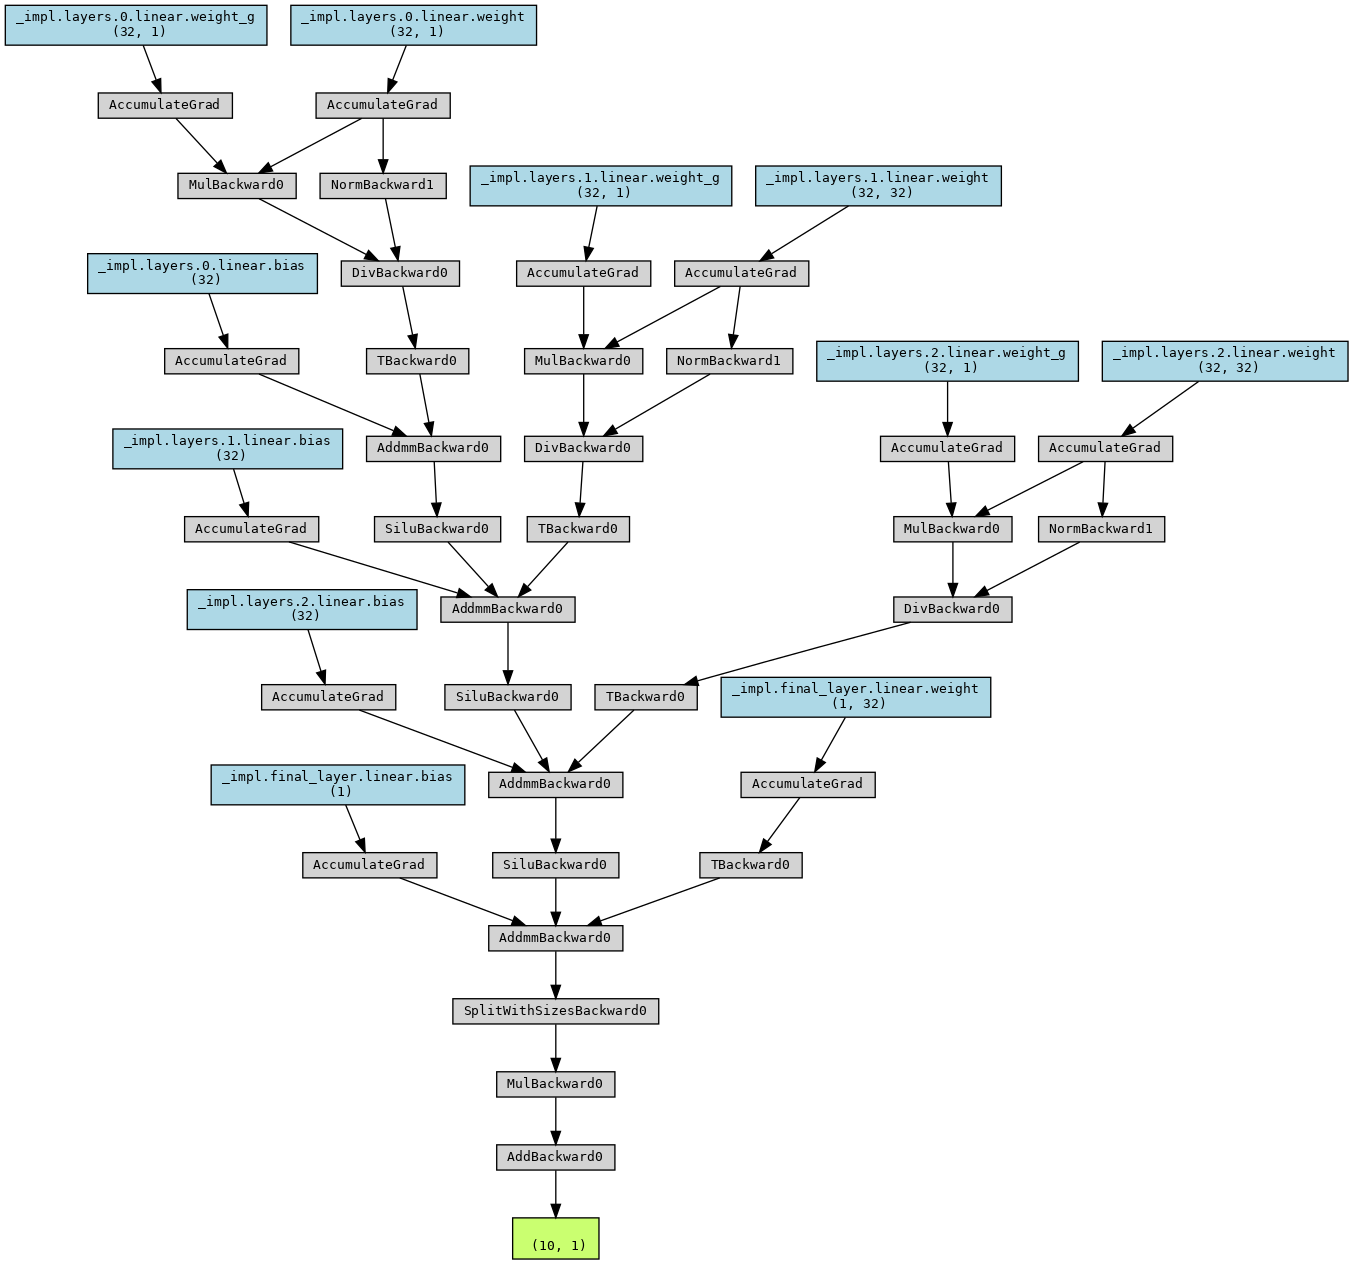

In [6]:
# visualize the network and symbolic equation in Modulus:
print(u_net)
print(eq.pprint())

# graphically visualize the PyTorch execution graph
!pip install torchviz
import torch
from torchviz import make_dot
from IPython.display import Image 
    
# pass dummy data through the model 
data_out = u_net({"x": (torch.rand(10, 1)),})
make_dot(data_out["u"], params=dict(u_net.named_parameters())).render("u_network", format="png")
display(Image(filename='./u_network.png'))

### 4. Create Domain and Add Constraints

As described earlier, we need to define a domain for training our neural network. The `Domain` holds all constraints as well as additional components needed in the training process. These additional components include inferencers, validators, and monitors. When developing in Modulus, constraints that the user defines are then added to the training `Domain` in order to create a collection of training objectives. The Domain and the configs are passed as inputs when using the `Solver` class. 

In [7]:
from modulus.domain import Domain

# make domain
domain = Domain()

Now let’s look into adding constraints to this domain. This can be thought of as adding specific constraints to the neural network optimization. For this physics-driven problem, these constraints are the boundary conditions and equation residuals. The goal is to satisfy the boundary conditions exactly, and ideally have the PDE residuals to go 0. These constraints can be specified within Modulus using classes like [`PointwiseBoundaryConstrant`](https://docs.nvidia.com/deeplearning/modulus/api/modulus.domain.constraint.html#modulus.domain.constraint.continuous.PointwiseBoundaryConstraint) and [`PointwiseInteriorConstraint`](https://docs.nvidia.com/deeplearning/modulus/api/modulus.domain.constraint.html#modulus.domain.constraint.continuous.PointwiseInteriorConstraint). A L2 loss (which is the default and can be modified) is then constructed from these constraints which is used by the optimizer to minimize on. Specifying the constraints in this fashion is called soft-constraints.

**Boundary constraints:** For generating a boundary condition, we need to sample the points on the required boundary/surface of the geometry, specify the nodes we would like to unroll/evaluate on these points, and then assign them the desired values.

A boundary can be sampled using the `PointwiseBoundaryConstraint` class. This will sample the entire boundary of the geometry we specify in the geometry argument, in this case both the endpoints of the 1D line. A particular boundary of the geometry can be sub-sampled by using a particular criterion using the `criteria` parameter. We will see its use in a later example. The desired values for the boundary condition are listed as a dictionary in the `outvar` argument. These dictionaries are then used when unrolling the computational graph (specified using the `nodes` argument) for training. The number of points to sample on each boundary are specified using the `batch_size` argument.

**Equations to solve:** The Custom PDE we defined is enforced on all the points in the interior. We will use the `PointwiseInteriorConstraint` class to sample points in the interior of the geometry. Again, the appropriate geometry is specified in the geometry argument and the equations to solve are specified as a dictionary input to the `outvar` argument. These dictionaries are then used when unrolling the computational graph (specified using the `nodes` argument) for training. For this problem we have `'custom_pde':0`. The argument `bounds`, determines the range for sampling the values for variables. 

In [8]:
from modulus.domain.constraint import PointwiseBoundaryConstraint, PointwiseInteriorConstraint

# bcs
bc = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=geo,
    outvar={"u": 0},
    batch_size=2,
)
domain.add_constraint(bc, "bc")

# interior
interior = PointwiseInteriorConstraint(
    nodes=nodes,
    geometry=geo,
    outvar={"custom_pde": 0},
    batch_size=100,
    bounds={x: (0, 1)},
)
domain.add_constraint(interior, "interior")

### 5. Create any Inferencers, Validators or Monitors

Let's create and inferencer object to visualize our results.

In [9]:
import numpy as np
from modulus.domain.inferencer import PointwiseInferencer

# add inferencer
inference = PointwiseInferencer(
    nodes=nodes,
    invar={"x": np.linspace(0, 1.0, 100).reshape(-1,1)},
    output_names=["u"],
)
domain.add_inferencer(inference, "inf_data")

### 6. Putting Everything Together: Solver and Training

We can create a solver by using the domain we just created along with the other configurations that define the optimizer choices using Modulus’ `Solver` class. The solver can then be executed using the solve method. 

In [10]:
# to make the logging work in the jupyter cells
# execute this cell only once
import logging
logging.getLogger().addHandler(logging.StreamHandler())

In [11]:
import os
from modulus.solver import Solver

# optional set appropriate GPU in case of multi-GPU machine
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
#os.environ["CUDA_VISIBLE_DEVICES"]="2"

# make solver
slv = Solver(cfg, domain)

# start solver
slv.solve()

attempting to restore from: /dli/task/jupyter_notebook/introduction/outputs
optimizer checkpoint not found
model u_network.pth not found
[step:          0] saved constraint results to outputs
[step:          0] record constraint batch time:  1.002e+00s
[step:          0] saved inferencer results to outputs
[step:          0] record inferencers time:  3.175e-03s
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
[step:          0] saved checkpoint to /dli/task/jupyter_notebook/introduction/outputs
[step:          0] loss:  1.207e+00
Attempting cuda graph building, this may take a bit...
[step:        100] loss:  1.662e-04, time/iteration:  2.651e+01 ms
[step:        200] loss:  4.514e-05, time/iteration:  2.

### 7. Visualizing the Results

The inference domain can be visualized, and the results can be plotted using `matplotlib`. The inferencer/validator writes the data to disk which we will use to make the plots. The output format for inferencers/validators can be selected by modifying the `save_filetypes` config. 

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/opt/conda/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/opt/conda/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/opt/conda/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
findfont: score(FontEntry(fname='/opt/conda/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='no

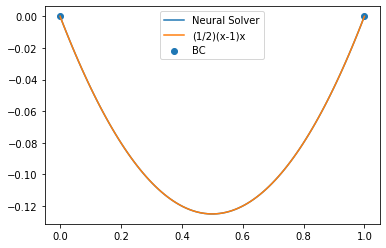

In [12]:
import matplotlib.pyplot as plt
import numpy as np
data = np.load('./outputs/inferencers/inf_data.npz', allow_pickle=True)
data = np.atleast_1d(data.f.arr_0)[0]
plt.figure()
x = data['x'].flatten()
pred_u = data['u'].flatten()
plt.plot(np.sort(x), pred_u[np.argsort(x)], label='Neural Solver')
plt.plot(np.sort(x), 0.5*(np.sort(x)*(np.sort(x)-1)), label='(1/2)(x-1)x')
x_np = np.array([0., 1.])
u_np = 0.5*(x_np-1)*x_np
plt.scatter(x_np, u_np, label='BC')
plt.legend()
plt.show()

## Next

Now that we've covered the typical structure of Modulus projects, we will turn our attention to a key advantage of neural network solvers over traditional numerical methods, namely, the ability to solve parameterized geometries and inverse problems.

Please continue to [the next notebook](Parameterized_Inverse.ipynb).